In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

## Feature Information:

**Stream aggregation:** 
- H: Stats summarizing the recent traffic from this packet's host (IP) 
- HH: Stats summarizing the recent traffic going from this packet's host (IP) to the packet's destination host. 
- HpHp: Stats summarizing the recent traffic going from this packet's host+port (IP) to the packet's destination host+port. Example 192.168.4.2:1242 -> 192.168.4.12:80 
- HH_jit: Stats summarizing the jitter of the traffic going from this packet's host (IP) to the packet's destination host. 

**Time-frame (The decay factor Lambda used in the damped window):**
- How much recent history of the stream is capture in these statistics: L5, L3, L1, ... 

**The statistics extracted from the packet stream:**
- weight: The weight of the stream (can be viewed as the number of items observed in recent history) 
- mean: ... 
- std: ... 
- radius: The root squared sum of the two streams' variances 
- magnitude: The root squared sum of the two streams' means 
- cov: an approximated covariance between two streams 
- pcc: an approximated covariance between two streams

In [46]:
benign_df = pd.read_csv('botnet_data_provision_sec_camera/benign_traffic.csv')
benign_df['label'] = 0

In [47]:
ack_df = pd.read_csv('botnet_data_provision_sec_camera/ack.csv')
ack_df['label'] = 1
ack_df.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,label
0,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.000000,...,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1
1,1.994987,60.0,0.000000e+00,1.996989,60.0,9.094947e-13,1.998995,60.0,9.094947e-13,1.999899,...,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1
2,2.994974,60.0,4.547474e-13,2.996981,60.0,9.094947e-13,2.998993,60.0,4.547474e-13,2.999899,...,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1
3,3.994964,60.0,4.547474e-13,3.996975,60.0,9.094947e-13,3.998991,60.0,4.547474e-13,3.999899,...,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1
4,4.994947,60.0,4.547474e-13,4.996965,60.0,0.000000e+00,4.998987,60.0,4.547474e-13,4.999899,...,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1


In [48]:
syn_df = pd.read_csv('botnet_data_provision_sec_camera/syn.csv')
syn_df['label'] = 2

In [49]:
scan0_df = pd.read_csv('botnet_data_provision_sec_camera/scan_0.csv')
scan0_df['label'] = 3

In [50]:
scan1_df = pd.read_csv('botnet_data_provision_sec_camera/scan_1.csv')
scan1_df['label'] = 4

In [51]:
all_df = pd.concat((benign_df, ack_df, syn_df, scan0_df, scan1_df))

In [52]:
all_df.shape

(314532, 116)

In [53]:
Y = all_df.loc[:, 'label']
X = all_df.loc[:, 'MI_dir_L5_weight':'HpHp_L0.01_pcc']

In [54]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=123)

In [55]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(235899, 115)
(78633, 115)
(235899,)
(78633,)


In [56]:
from sklearn.preprocessing import MinMaxScaler

In [57]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [58]:
pca_3 = PCA(n_components=3, random_state=123)
pca_3.fit(x_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=123,
  svd_solver='auto', tol=0.0, whiten=False)

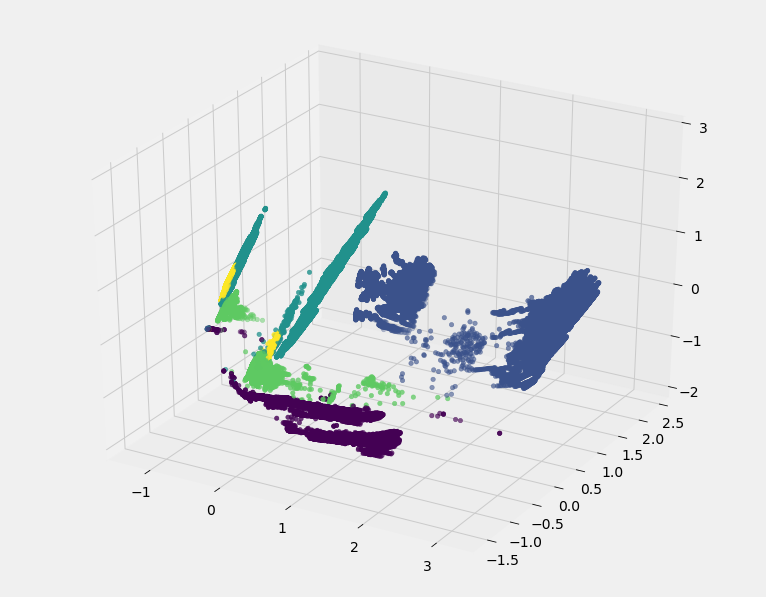

In [59]:
p3_train = pca_3.transform(x_train_scaled)
plt.style.use('fivethirtyeight')

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot(111, projection = '3d')
x_ax = np.array(p3_train[:, 0]).flatten()
y_ax = np.array(p3_train[:, 1]).flatten()
z_ax = np.array(p3_train[:, 2]).flatten()
ax.scatter(x_ax, y_ax, z_ax, c = y_train, marker = 'o')
plt.show()

In [33]:
from sklearn.ensemble import AdaBoostClassifier

In [34]:
ada_boost_classifier = AdaBoostClassifier(
    base_estimator=None,
    n_estimators=50,
    learning_rate=1.0,
    algorithm='SAMME.R',
    random_state=None)

In [35]:
ada_boost_classifier.fit(x_train_scaled, y_train)
y_hat = ada_boost_classifier.predict(x_test_scaled)

In [37]:
print(confusion_matrix(y_test, y_hat))

[[    0     0 15483     0     4]
 [    0 15255     0     0     0]
 [    0     0 16421     0     2]
 [    0     0  7391     0     0]
 [    0     0     4     0 24073]]


In [60]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)

In [61]:
knn_classifier.fit(x_train_scaled, y_train)
y_hat = knn_classifier.predict(x_test_scaled)

In [62]:
accuracy_score(y_test, y_hat)

0.9998728269301693

In [63]:
print(confusion_matrix(y_test, y_hat))

[[15531     0     0     1     0]
 [    1 14998     1     0     0]
 [    0     0 16578     1     0]
 [    2     0     0  7303     0]
 [    2     0     1     1 24213]]


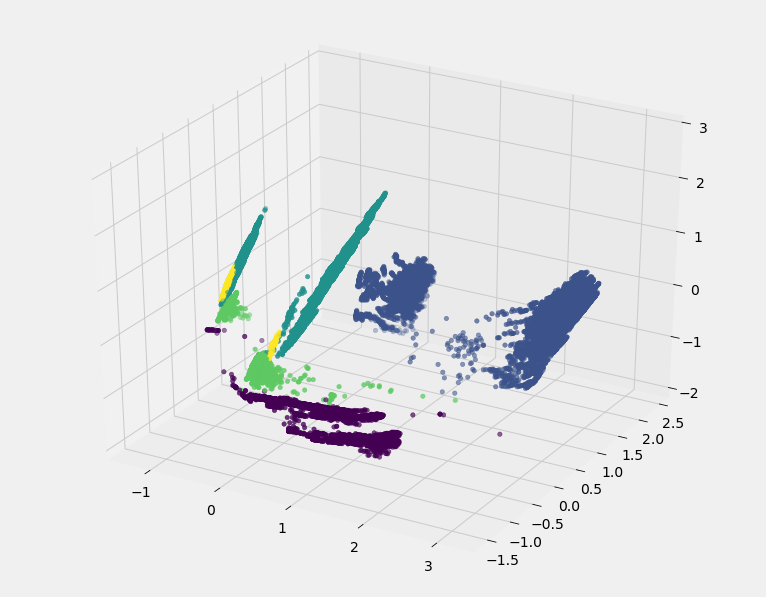

In [64]:
p3_test = pca_3.transform(x_test_scaled)

fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot(111, projection = '3d')
x_ax = np.array(p3_test[:, 0]).flatten()
y_ax = np.array(p3_test[:, 1]).flatten()
z_ax = np.array(p3_test[:, 2]).flatten()
ax.scatter(x_ax, y_ax, z_ax, c = y_hat, marker = 'o')
plt.show()

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
random_forest = RandomForestClassifier(n_estimators='warn',
    criterion='entropy',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=123,
    verbose=0,
    warm_start=False,
    class_weight=None)

In [67]:
random_forest.fit(x_train, y_train)
y_hat = random_forest.predict(x_test)

C:\Users\ericn\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [68]:
print(confusion_matrix(y_test, y_hat))

[[15532     0     0     0     0]
 [    0 14999     1     0     0]
 [    0     0 16579     0     0]
 [    0     0     0  7305     0]
 [    0     0     0     1 24216]]


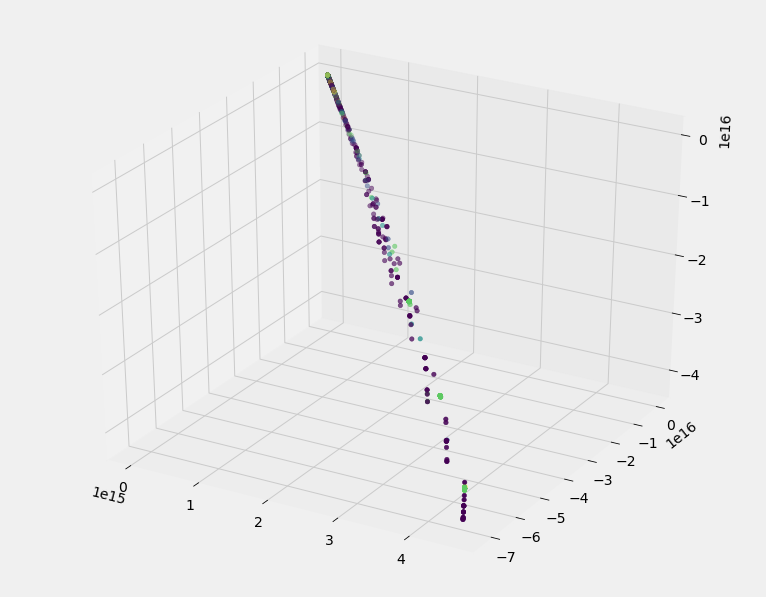

In [70]:
p3_test = pca_3.transform(x_test)

fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot(111, projection = '3d')
x_ax = np.array(p3_test[:, 0]).flatten()
y_ax = np.array(p3_test[:, 1]).flatten()
z_ax = np.array(p3_test[:, 2]).flatten()
ax.scatter(x_ax, y_ax, z_ax, c = y_hat, marker = 'o')
plt.show()

In [71]:
accuracy_score(y_test, y_hat)

0.9999745653860339